# Pricing of European Call and Put options with the COS method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

In [2]:
def CallPutOptionPriceCOSMthd(cf, CP, S0, r, tau, K, N, L):
    
    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - Interest rate (constant)
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)

    # Reshape K to become a column vector
    K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)
    i = complex(0.0,1.0) 
    
    x0 = np.log(S0 / K)   
    
    # Truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for put prices  
    H_k = CallPutCoefficients(CP,a,b,k)
       
    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
         
    return value

In [3]:
""" 
Determine coefficients for put prices 
"""
def CallPutCoefficients(CP,a,b,k):
    if str(CP).lower()== "c" or str(CP).lower()== "1":                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k = 2.0 / (b - a) * (Chi_k - Psi_k)  
        
    elif str(CP).lower()== "p" or str(CP).lower()== "-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

In [4]:
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi": chi,"psi": psi }
   
    return value

In [5]:
def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    #Black-Scholes Call option price
    
    cp = str(CP).lower()
    
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    
    if cp == "c" or cp == "1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    
    elif cp == "p" or cp =="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    
    return value

In [6]:
# Define the parameters

i = complex(0.0,1.0)
CP = "c"
S0 = 100.0
r = 0.1
tau = 0.1
sigma = 0.25
K = [80.0, 100.0, 120.0]
N = 32
L = 10

In [7]:
# Definition of the characteristic function for GBM, this is an input for the COS method
# Note that the Chf does not include "+iuX(t_0)" as this coefficient
# is already included in the evaluation
# In the book we denote this function by \varphi(u)

cf = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * tau - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * tau)

In [8]:
# Timing results 

NoOfIterations = 100

time_start = time.time() 
for k in range(0,NoOfIterations,1):
    val_COS = CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L)
time_stop = time.time()

print("It took {0} seconds to price.".format((time_stop-time_start)/float(NoOfIterations)))

It took 0.00018927812576293945 seconds to price.


In [9]:
# Evaluate analytic Black Scholes equation
val_Exact = BS_Call_Option_Price(CP, S0, K, sigma, tau, r)

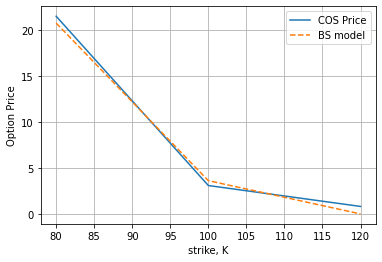

In [10]:
plt.plot(K,val_COS)
plt.plot(K,val_Exact,'--')
plt.xlabel("strike, K")
plt.ylabel("Option Price")
plt.legend(["COS Price","BS model"])
plt.grid()    

In [11]:
# Error computation

error = []
for i in range(0,len(K)):
    error.append(np.abs(val_COS[i]-val_Exact[i])[0])
    print("Abs error for strike {0} is equal to {1:.2E}".format(K[i],error[i]))
        


Abs error for strike 80.0 is equal to 7.44E-01
Abs error for strike 100.0 is equal to 5.28E-01
Abs error for strike 120.0 is equal to 8.13E-01
